In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
!pip install mne
!pip install tensorflow_addons

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
import mne
from mne import io
import os
import pandas as pd
import keras
from keras.layers import *
from keras.models import *
import tensorflow_addons
from keras import backend as K
import tensorflow_addons as tfa

In [ ]:
def calculate_FAR_Sensitivity(original_seq, predicted_seq, current_ID):

  # to calculate FAR - get both counts
  org_len = len(original_seq) # they are the same but anyway... for clarity
  org_count, org_start, org_end = find_seizures(original_seq, org_len)

  pred_len = len(predicted_seq) # they are the same but anyway... for clarity
  pred_count, pred_start, pred_end = find_seizures(predicted_seq, pred_len)

  # seizure counter:
  total_seizure_count_predicted = 0
  total_seizure_count_real = len(org_count)

  # using these counts - need to to first find if seizures in org are in predicted at least partially
  for i in range(0, len(org_count)): # iterate through all seizures found in original

    for j in range(0, len(pred_count)): # iterate through predicted seizure log
      # 4 cases - either wholly inside the actual seizure, encompass all the seizure and beyond, partially find on one side, partially on the other
      if (pred_start[j] <= org_start[i] and pred_end[j] >= org_end[i]) or (pred_start[j] <= org_start[i] and (org_start[i] <= pred_end[j] <= org_end[i])) or ((org_start[i] <= pred_start[j] <= org_end[i]) and pred_end[j] >= org_end[i]) or (org_start[i] <= pred_start[j] and pred_end[j] <= org_end[i]):
        total_seizure_count_predicted += 1
      
      else:
        continue 

  
  # print("predicted:", total_seizure_count_predicted)
  # print("real:", total_seizure_count_real)
  print("Total seizures predicted:", total_seizure_count_predicted)
  print("Total seizures real:", total_seizure_count_real)

  if total_seizure_count_real == 0:
    sensitivity = 1
  
  else:
    sensitivity = total_seizure_count_predicted/total_seizure_count_real
  
  # just extract number of false alarams
  pred_count_number = len(pred_count)

  far_count = pred_count_number - total_seizure_count_predicted

  # To calculate FAR - take the length of the recording in hours and calculate amount of false seizures/hour
  hours = get_rec_hours(current_ID)

  print("Heuristic hours: {}, Real hours: {}.".format(hours_2, hours))


  print("Recording length: {} hours".format(hours))

  far = far_count/hours
  
  print("The prediction sensitivity: ", sensitivity)
  print("The prediction False Alarm Rate FA/h: ", far )

  return far, sensitivity

In [ ]:
def get_rec_hours(ID):
  # Save some computation/data extraction time

  if ID == 'SUBJ-1a-025':
    rec_length = 106.39
  
  elif ID == 'SUBJ-1a-163':
    rec_length = 93.46
  
  elif ID == 'SUBJ-1a-177':
    rec_length = 107.59

  elif ID == 'SUBJ-1b-178':
    rec_length = 106.88

  elif ID == 'SUBJ-4-198':
    rec_length = 27.88

  elif ID == 'SUBJ-4-203':
    rec_length = 99.08

  elif ID == 'SUBJ-1a-226':
    rec_length = 71.28

  elif ID == 'SUBJ-6-256':
    rec_length = 184.21

  elif ID == 'SUBJ-6-275':
    rec_length = 268.38

  elif ID == 'SUBJ-6-276':
    rec_length = 198.43

  elif ID == 'SUBJ-6-291':
    rec_length = 92.97

  elif ID == 'SUBJ-1b-307':
    rec_length = 80.23

  elif ID =='SUBJ-1a-349':
    rec_length = 101.54

  elif ID == 'SUBJ-1a-353':
    rec_length = 113.22

  elif ID == 'SUBJ-6-357':
    rec_length = 270.23


  return rec_length

In [ ]:
def eliminate_isolates(sequence, threshold):
  # threshold sets the prediction cutoff - how many consequite seizures are required to escape elimination (seizures usually typical length etc.)
  seq_length = len(sequence)
  seq_count, seq_start, seq_end = find_seizures(sequence, seq_length)
  final_seq = sequence

  for k in range(0, len(seq_count)):
    if seq_count[k] < threshold:
  # alter the sequence inside the below threshold segment
      for l in range(seq_start[k], seq_end[k]+1):
        final_seq[l] = 0  
        
  return final_seq

In [ ]:
def predictions_post_processing(real, predictions, seizure_count, start_seizure, stop_seizure, max_distance_filter, threshold):
  # max distance filter allows for tuning of the concatenation scope
  # function concatenates closeby seizure events, and discards isolated positive predictions as false
  # 10 distance scope = approx 20 seconds
  
  processed_predictions = predictions

  # concatenation portion of the function
  for i in range(0, len(seizure_count)-1):
    distance_to_next_seizure = start_seizure[i+1] - stop_seizure[i]
    if distance_to_next_seizure < max_distance_filter:
     
    # Fill the 0 gaps in between with 1s
     for j in range(stop_seizure[i], start_seizure[i+1], 1):
       processed_predictions[j] = 1
    
    else: 
      continue

  # pruning most probably incorrect predictions - isolated, not long enough etc
  # threshold controls how many required to escape cutoff
  final_prediction = eliminate_isolates(processed_predictions, threshold)
  padding = 25
  # final_prediction = pad_seizure_sites(final_prediction, padding)

  return final_prediction

In [ ]:
def pad_seizure_sites(sequence, pad):

  seq_length = len(sequence)
  seq_count, seq_start, seq_end = find_seizures(sequence, seq_length)

  if len(seq_start)!=len(seq_end):
    seq_end.append(seq_length)
  
  else:
    pass

  for i in range(0, len(seq_count)):

    if seq_start[i] > pad:
      for k in range(seq_start[i]-pad, seq_start[i]):
        sequence[k] = 1

    else:
      pass

    if seq_end[i] < seq_length - pad:    
                                
      for j in range(seq_end[i], seq_end[i]+pad):
        sequence[j] = 1

    else:
      pass

  final_sequence = sequence

  return final_sequence

In [ ]:
def find_seizures(binary_predictions, max_len):
  # take in the list
  # take max_seizure length - arbitrary - need to optimize 
  # 
  # initialize count and index start monitors
  counts = []
  index_at_seizure_start = []
  index_at_seizure_end = []
  length = 0

  while length < max_len:
    
    # initialiez count, switch and iterator j
    count = 1
    switch = True
    j = 1
  
    if binary_predictions[length] == 1:

      # count consecutive ones: 
      while switch == True:
        if length+j < max_len:

          if binary_predictions[length+j] == 1:
            count += 1
            j += 1
          elif binary_predictions[length+j] == 0:
            ending_j = length + j - 1
            index_at_seizure_end.append(ending_j)
            break
        
        else:
          break

      counts.append(count)
      index_at_seizure_start.append(length)
      # print(length)
      # print(j)

      length = length + j
      # print(length)
      # print(j)

    else:
      length +=1
  

  # If final seizure till the end:
  if len(index_at_seizure_start) == len(index_at_seizure_end):
    pass
  
  elif len(index_at_seizure_start) == len(index_at_seizure_end) + 1:
    index_at_seizure_end.append(max_len)

  else:
    print("INDEXING ISSUE")
  
  return counts, index_at_seizure_start, index_at_seizure_end

In [ ]:
def vectorized_stride(array, clearing_time_index, max_time, sub_window_size,
                         stride_size):
    start = clearing_time_index + 1 - sub_window_size + 1

    sub_windows = (
            start +
            np.expand_dims(np.arange(sub_window_size), 0) +
            # Create a rightmost vector as [0, V, 2V, ...].
            np.expand_dims(np.arange(max_time + 1, step=stride_size), 0).T
    )

    return array[sub_windows]

In [ ]:
def segmentor_test(subject):
  print('__________________________________________________________________________________________')
  print("Patient: ",subject[0])
  # test array placeholder
  testX = np.empty(shape=[0])
  # test label array placeholder
  testY = np.empty(shape=[0])

  testX_unaltered = np.empty(shape=[0])
  testY_unaltered = np.empty(shape=[0])

  paths = []
  rec_names = []
  with os.scandir('/content/drive/MyDrive/Colab Notebooks/test_patients/{}/'.format(subject[0])) as it:
      for entry in it:
          if entry.name.endswith(".npy") and entry.is_file():
              # print(entry.name, entry.path)
              paths.append(entry.path)
              rec_names.append(entry.name)

  print("ALL PATIENT RECORDINGS: ", rec_names)

  for i in range(0, len(paths)):
    
    print("Current recording:", rec_names[i])
    subj_array = np.load(paths[i])
    # Get data to single arrays
    x_subj = subj_array[:, 0]
    y_subj = subj_array[:, 1]

    x_subj_unaltered = subj_array[:, 0]
    y_subj_unaltered = subj_array[:, 1]

    x_subj = filter_sequence(x_subj, rec_names[i])

    testX = np.concatenate((testX, x_subj), axis = 0)
    testY = np.concatenate((testY, y_subj), axis = 0)

    testX_unaltered = np.concatenate((testX_unaltered, x_subj_unaltered), axis = 0)
    testY_unaltered = np.concatenate((testY_unaltered, y_subj_unaltered), axis = 0)

  # Standardize the data
  test_data_std = (testX- testX.mean())/(testX.std()) 
  mean_recording = testX.mean()
  std_recording = testX.std()

  # extract length of recording
  length = np.size(test_data_std)
  recording_length = int(length - 1)


  # slice up training data
  x_test_sliced = vectorized_stride(test_data_std, 1, max_time=recording_length, sub_window_size=1000,
                                       stride_size=1000)
  # slice up the label data
  y_test_sliced = vectorized_stride(testY, 1, max_time=recording_length, sub_window_size=1000,
                                       stride_size=1000)
  

  x_test_sliced_unaltered = vectorized_stride(testX_unaltered, 1, max_time=recording_length, sub_window_size=1000,
                                       stride_size=1000)
  # slice up the label data
  y_test_sliced_unaltered = vectorized_stride(testY_unaltered, 1, max_time=recording_length, sub_window_size=1000,
                                       stride_size=1000)
  
  # touch up the label array (tuple to single value)
  rows, columns = np.shape(y_test_sliced)

  y_data = np.zeros(rows)
  # iterate through rows:
  for i in range(0, rows):
      # iterate through row
      if any(y_test_sliced[i]) == 1:
          # print("Seizure")
          y_data[i] = 1
      else:
          continue

  x_data = x_test_sliced
  y_data = y_data.astype(int)
  y_tuple = y_test_sliced

  return x_data, y_data, y_tuple, mean_recording, std_recording, x_test_sliced_unaltered

In [ ]:
def filter_sequence(sequence, patient_data):

  lower_sampling = ['train025','train127', 'train163', 'train198', 'train203']

  lower_freq = 250

  higher_sampling = ['train177', 'train226', 'train178', 'train307', 'train256', 'train275',
                      'train291', 'train276', 'train353', 'train349', 'train357']
  higher_freq = 256

  truncated_name = patient_data[:8]

  notch_freqs = np.arange(50, 101, 50)

  if truncated_name in lower_sampling:
    sequence = mne.filter.notch_filter(x = sequence, Fs = lower_freq, freqs = 50, method = 'iir', iir_params = None, verbose = 0)
    #sequence = mne.filter.notch_filter(x = sequence, Fs = lower_freq, freqs = 100, method = 'iir', iir_params = None, verbose = 0)
    filtered_sequence =  mne.filter.filter_data(data = sequence, sfreq = lower_freq, l_freq = 10, h_freq = 50, method='iir', iir_params = None, verbose = 0)

  
  elif truncated_name in higher_sampling:
    sequence = mne.filter.notch_filter(x = sequence, Fs = higher_freq, freqs = 50, method = 'iir', iir_params = None, verbose = 0)
    #sequence = mne.filter.notch_filter(x = sequence, Fs = higher_freq, freqs = 100, method = 'iir', iir_params = None, verbose = 0)
    filtered_sequence =  mne.filter.filter_data(data = sequence, sfreq = higher_freq, l_freq = 10, h_freq = 50, method='iir', iir_params = None, verbose = 0)

  else: 
    pass

  return filtered_sequence

In [ ]:

#target = ['patient_025'] # DONE [X]
#target = ['patient_163'] # DONE [X]
#target = ['patient_177'] # DONE [X]
#target = ['patient_178'] # DONE [X]
#target = ['patient_198'] # DONE [X]
#target = ['patient_203'] # DONE [X]
#target = ['patient_226'] # DONE [X]
#target = ['patient_256'] # DONE [X]
#target = ['patient_275'] # DONE [X] 
#target = ['patient_276'] # DONE [X]
#target = ['patient_291'] # DONE [X]
#target = ['patient_307'] # DONE [X]
#target = ['patient_349'] # DONE [X]
#target = ['patient_353'] # DONE [X]
#target = ['patient_357'] # DONE [X]

#patient_ID = 'SUBJ-1a-025' # Done [X]
#patient_ID = 'SUBJ-1a-163' # Done [X]
#patient_ID = 'SUBJ-1a-177' # Done [X]
#patient_ID = 'SUBJ-1b-178' # Done [X]
#patient_ID = 'SUBJ-4-198' # Done [X] 
#patient_ID = 'SUBJ-4-203' # Done [X]
#patient_ID = 'SUBJ-1a-226' # Done [X]
#patient_ID = 'SUBJ-6-256' # Done [X]
#patient_ID = 'SUBJ-6-275' # Done [X] 
#patient_ID = 'SUBJ-6-276' # Done [X]
#patient_ID = 'SUBJ-6-291' # Done [X] 
#patient_ID = 'SUBJ-1b-307' # Done [X]
#patient_ID = 'SUBJ-1a-349' # Done [X]
#patient_ID = 'SUBJ-1a-353' # Done [X]
#patient_ID = 'SUBJ-6-357' # Done [X]


In [ ]:
test_X, test_Y, _, test_mean, test_std, orgX = segmentor_test(target)
rows_test, columns_test = np.shape(test_X)
test_X = test_X.reshape(rows_test, columns_test, 1)
print(test_mean, test_std)

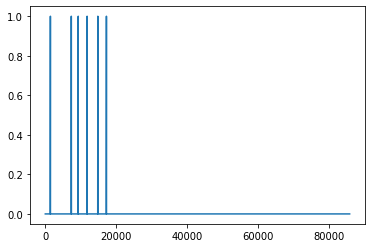

In [ ]:
plt.plot(test_Y)

MODELLING

Model Characterization

In [ ]:
patient = target[0]
log_name = patient[0:7] + patient[8:11]
chosen_model = log_name
print(log_name)

patient291


In [ ]:
fl = tfa.losses.SigmoidFocalCrossEntropy()

In [ ]:
def focal_loss_custom(alpha, gamma):
   def binary_focal_loss(y_true, y_pred):
      fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
      y_true_K = K.ones_like(y_true)
      focal_loss = fl(y_true, y_pred)
      return focal_loss
   return binary_focal_loss

In [ ]:
from keras.models import load_model

path_model = '/content/drive/MyDrive/Colab Notebooks/patient_MODELS_GPU_6_altImbalanceStrategy/GPU_Checkpoints_6/{}_CNN_LSTM_alt_strategyoptimal_checkpoint'.format(chosen_model)

model = load_model(path_model,custom_objects={'binary_focal_loss':focal_loss_custom})

In [ ]:
log_path = '/content/drive/MyDrive/Colab Notebooks/patient_MODELS_GPU_6_altImbalanceStrategy/GPU_Training_logs_6/{}_CNN_LSTM_alt_strategy_training.log'.format(log_name)
log_data = pd.read_csv(log_path, sep =',', engine = 'python')
history = log_data

In [ ]:
model.summary()

In [ ]:
# summarize history for accuracy
plt.plot(history['binary_accuracy'])
plt.plot(history['val_binary_accuracy'])
plt.title('Model accuracy [{}]'.format(patient_ID))
plt.ylabel('binary accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss [{}]'.format(patient_ID))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_y_pred = model.predict(test_X)

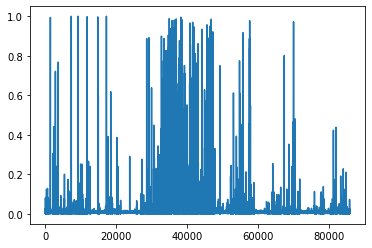

In [ ]:
plt.plot(test_y_pred)

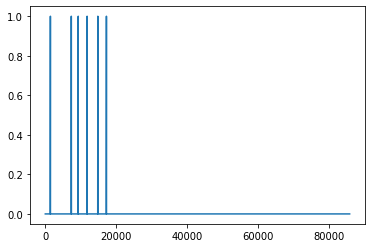

In [ ]:
plt.plot(test_Y)

In [ ]:
predictions = np.where(np.array(test_y_pred) >= 0.9,1, 0).tolist()

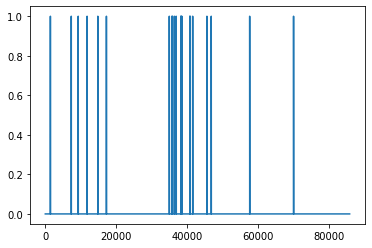

In [ ]:
plt.plot(predictions)

In [ ]:
flat_predictions =  [item for sublist in predictions for item in sublist]
flat_predictions = [ int(x) for x in flat_predictions ]

visualize_predictions =  [item for sublist in predictions for item in sublist]
visualize_predictions = [ int(x) for x in flat_predictions ]


In [ ]:
flat_predictions_2 = flat_predictions
visualize_real = test_Y


In [ ]:
list_len = len(flat_predictions)
counts, start, end = find_seizures(flat_predictions, list_len)

In [ ]:
count_real, start_real, end_real = find_seizures(test_Y, list_len)

In [ ]:
print("Raw FAR/SPEC for PATIENT {}".format(patient_ID))
far, spec = calculate_FAR_Sensitivity(test_Y, flat_predictions, patient_ID)
print("Seizure site coverage: ")

STRAIGHT FAR/SPEC PATIENT SUBJ-6-291
Total seizures predicted: 17
Total seizures real: 6
Heuristic hours: 95.20333333333333, Real hours: 92.97.
Recording length: 92.97 hours
The prediction sensitivity:  2.8333333333333335
The prediction False Alarm Rate FA/h:  0.16134236850596967
Seizure site coverage: 


In [ ]:
print("Initial prediction counts")
print(counts)
print(start)
print(end)
print(len(counts))

print(1/19)
print(6/38)

Initial prediction counts
[2, 4, 1, 1, 1, 1, 3, 3, 1, 2, 1, 5, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1425, 1428, 1433, 1435, 7307, 7311, 7313, 9266, 11763, 11769, 14778, 14780, 17195, 17197, 17201, 17204, 17206, 34908, 35689, 35728, 36325, 36852, 38162, 38227, 38436, 40688, 40775, 41490, 45503, 46719, 57536, 69891]
[1426, 1431, 1433, 1435, 7307, 7311, 7315, 9268, 11763, 11770, 14778, 14784, 17195, 17197, 17202, 17204, 17206, 34908, 35689, 35728, 36325, 36852, 38162, 38227, 38436, 40688, 40775, 41490, 45503, 46719, 57536, 69891]
32
0.05263157894736842
0.15789473684210525


In [ ]:
print("Real counts")
print(count_real)
print(start_real)
print(end_real)

Real counts
[28, 31, 29, 29, 31, 30]
[1410, 7292, 9248, 11748, 14759, 17181]
[1437, 7322, 9276, 11776, 14789, 17210]


In [ ]:
final_pred= predictions_post_processing(test_Y, flat_predictions_2, counts, start, end, 5, 2)

In [ ]:
count_final, start_final, end_final = find_seizures(final_pred, list_len)

In [ ]:
print("Final post-processed counts")
print(count_final)
print(start_final)
print(end_final)

Final post-processed counts
[11, 9, 3, 2, 7, 12]
[1425, 7307, 9266, 11769, 14778, 17195]
[1435, 7315, 9268, 11770, 14784, 17206]
0.5
0.15789473684210525


In [ ]:
print("Postprocessed FAR/SPEC FOR PATIENT {}".format(patient_ID))
far, spec = calculate_FAR_Sensitivity(test_Y, final_pred, patient_ID)

Postprocessed FAR/SPEC FOR PATIENT SUBJ-6-291
Total seizures predicted: 6
Total seizures real: 6
Heuristic hours: 95.20333333333333, Real hours: 92.97.
Recording length: 92.97 hours
The prediction sensitivity:  1.0
The prediction False Alarm Rate FA/h:  0.0


In [ ]:
# Showing the wrongly IDd seizures:
# 1. SHOW CORRECT SEIZURE - need count, start, end - some section
# 2. Take incorrectly IDd seizures - visualize + compare
# STANDARDIZE: test_data_std = (testX- testX.mean())/(testX.std())
# DESTANDARDIZE: testX = test_data_std * testX.std() + testX.mean() ///// X_original = X_standardized * X_stdev + X_mean
from math import sqrt
def visualise_real_seizure_site(non_transformed_sequence, sequence_data, label_data, pred_data, mean_test, stdev_test, start_window, end_window):

  # get counts and seizure sites locations
  list_len = len(label_data)
  count_test, start_test, end_test = find_seizures(label_data, list_len)

  for i in range(0, len(count_test)):

    # Get seizure site data
    patient_seizure_site = sequence_data[start_test[i]:end_test[i]+1]

    untouched = non_transformed_sequence[start_test[i]:end_test[i]+1]

    # Get prediction for the site
    # patient_predictions_onsite = pred_data[start_test[i]:end_test[i]]
    # patient_predicitons_onsite

    # Get shape of the seizure site array
    rows, columns,_ = np.shape(patient_seizure_site)

    # reshape to 2D format:
    patient_seizure_site = patient_seizure_site.reshape(rows, columns)

    untouched = untouched.reshape(rows, columns)


    whole_seizure_site = np.ndarray.flatten(patient_seizure_site)
    whole_untouched = np.ndarray.flatten(untouched)


    time_on_site = list(range(0, len(whole_seizure_site)))
    #time_on_site_seconds = time_on_site*4/4000
    time_on_site_seconds= [x*4/1000 for x in time_on_site]


    #________________________PLOT DESTANDARDIZED________________________

    whole_seizure_site_destandardized = whole_seizure_site *stdev_test + mean_test
    # print(whole_seizure_site)
    # print(np.shape(whole_seizure_site_destandardized))
    plt.plot(time_on_site_seconds, whole_seizure_site_destandardized, color = 'k',alpha = 0.85)


    #for i in range(10, 50, 3):
     # plt.axvspan(i, i+1, color = 'r', alpha = 0.5)
    
    for k in range(0, len(start_window)):
      plt.axvspan(start_window[k], end_window[k], color = 'r', alpha = 0.5)

    #plt.axvspan(76, 92, color = 'r', alpha = 0.5)

    #plt.axvspan(60, 64, color = 'r', alpha = 0.5)


    plt.title('{} Seizure Site {}'.format(patient_ID, i+1), pad = 10)
    plt.ylabel('Voltage [V]')
    plt.xlabel('Time [s]')
    plt.legend(['sEMG SD'], loc='upper left')
    plt.show()
    

    #________________________PLOT untouched________________________


    plt.plot(time_on_site_seconds, whole_untouched, color = 'k',alpha = 0.85)

    for k in range(0, len(start_window)):
      plt.axvspan(start_window[k], end_window[k], color = 'r', alpha = 0.5)


    #plt.axvspan(76, 92, color = 'r', alpha = 0.5)

    #plt.axvspan(60, 64, color = 'r', alpha = 0.5)



    plt.title('{} Seizure Site {}'.format(patient_ID, i+1), pad = 10)
    plt.ylabel('Voltage [V]')
    plt.xlabel('Time [s]')
    plt.legend(['sEMG SD'], loc='upper left')
    plt.show()



    #____________________ RMS CALCULATION___________________________________
    print(time_on_site_seconds)
    print(type(time_on_site_seconds))

    print(time_on_site_seconds[-1])
    print(int(time_on_site_seconds[-1]))
    x_RS_total = np.sum(np.square(whole_seizure_site_destandardized))
    x_RMS_per_second = sqrt((np.sum(np.square(whole_seizure_site_destandardized)))/int(time_on_site_seconds[-1]))
    x_RMS_proper = sqrt((np.sum(np.square(whole_seizure_site_destandardized)))/len(whole_seizure_site_destandardized))
    print("RS per SECOND OF RECORDING: ", x_RMS_per_second)
    print("RMS proper formula: ", x_RMS_proper )
    print("RMS cumulative", x_RS_total)


  return True

In [ ]:
print("Initial prediction counts")
print(counts)
print(start)
print(end)
print(len(counts))
'''
print("Final post-processed counts")
print(count_final)
print(start_final)
print(end_final)
'''
print("Real counts")
print(count_real)
print(start_real)
print(end_real)


Initial prediction counts
[2, 4, 1, 1, 1, 1, 3, 3, 1, 2, 1, 5, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1425, 1428, 1433, 1435, 7307, 7311, 7313, 9266, 11763, 11769, 14778, 14780, 17195, 17197, 17201, 17204, 17206, 34908, 35689, 35728, 36325, 36852, 38162, 38227, 38436, 40688, 40775, 41490, 45503, 46719, 57536, 69891]
[1426, 1431, 1433, 1435, 7307, 7311, 7315, 9268, 11763, 11770, 14778, 14784, 17195, 17197, 17202, 17204, 17206, 34908, 35689, 35728, 36325, 36852, 38162, 38227, 38436, 40688, 40775, 41490, 45503, 46719, 57536, 69891]
32
Real counts
[28, 31, 29, 29, 31, 30]
[1410, 7292, 9248, 11748, 14759, 17181]
[1437, 7322, 9276, 11776, 14789, 17210]


In [ ]:
# Choice for region visualisation
window_start = []
window_end = []

pred_start = 17195 
pred_end = 17195 
org_start = 17181

seizure_end = (pred_end - org_start)*4 + 4

seizure_start = (pred_start - org_start)*4

window_start.append(seizure_start)
window_end.append(seizure_end)

print(seizure_start,seizure_end)
'''
pred_start = 17197
pred_end = 17197
org_start = 17181

seizure_end = (pred_end - org_start)*4 + 4

seizure_start = (pred_start - org_start)*4
window_start.append(seizure_start)
window_end.append(seizure_end)

print(seizure_start,seizure_end)
'''

56 60
64 68
80 104
108 112


'\n\npred_start = 16355\npred_end = 16356\norg_start = 16339\n\nseizure_end = (pred_end - org_start)*4 + 4\n\nseizure_start = (pred_start - org_start)*4\nwindow_start.append(seizure_start)\nwindow_end.append(seizure_end)\n\nprint(seizure_start,seizure_end)\n\npred_start = 4963\npred_end = 4964\norg_start = 4931\n\nseizure_end = (pred_end - org_start)*4 + 4\n\nseizure_start = (pred_start - org_start)*4\nwindow_start.append(seizure_start)\nwindow_end.append(seizure_end)\n\nprint(seizure_start,seizure_end)\n\nprint(window_start)\nprint(window_end)\n\npred_start = 4967\npred_end = 4971\norg_start = 4931\n\nseizure_end = (pred_end - org_start)*4 + 4\n\nseizure_start = (pred_start - org_start)*4\nwindow_start.append(seizure_start)\nwindow_end.append(seizure_end)\n\nprint(seizure_start,seizure_end)\n\nprint(window_start)\nprint(window_end)\n'

In [ ]:
non_transformed = orgX.reshape(rows_test, columns_test, 1)
test_X_visualization = test_X
test_Y_visualization = test_Y

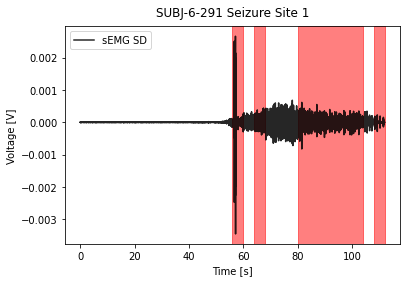

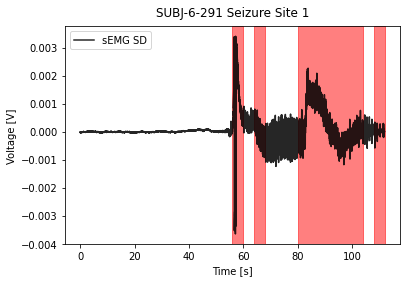

[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036, 0.04, 0.044, 0.048, 0.052, 0.056, 0.06, 0.064, 0.068, 0.072, 0.076, 0.08, 0.084, 0.088, 0.092, 0.096, 0.1, 0.104, 0.108, 0.112, 0.116, 0.12, 0.124, 0.128, 0.132, 0.136, 0.14, 0.144, 0.148, 0.152, 0.156, 0.16, 0.164, 0.168, 0.172, 0.176, 0.18, 0.184, 0.188, 0.192, 0.196, 0.2, 0.204, 0.208, 0.212, 0.216, 0.22, 0.224, 0.228, 0.232, 0.236, 0.24, 0.244, 0.248, 0.252, 0.256, 0.26, 0.264, 0.268, 0.272, 0.276, 0.28, 0.284, 0.288, 0.292, 0.296, 0.3, 0.304, 0.308, 0.312, 0.316, 0.32, 0.324, 0.328, 0.332, 0.336, 0.34, 0.344, 0.348, 0.352, 0.356, 0.36, 0.364, 0.368, 0.372, 0.376, 0.38, 0.384, 0.388, 0.392, 0.396, 0.4, 0.404, 0.408, 0.412, 0.416, 0.42, 0.424, 0.428, 0.432, 0.436, 0.44, 0.444, 0.448, 0.452, 0.456, 0.46, 0.464, 0.468, 0.472, 0.476, 0.48, 0.484, 0.488, 0.492, 0.496, 0.5, 0.504, 0.508, 0.512, 0.516, 0.52, 0.524, 0.528, 0.532, 0.536, 0.54, 0.544, 0.548, 0.552, 0.556, 0.56, 0.564, 0.568, 0.572, 0.576, 0.58, 0.584, 0.588,

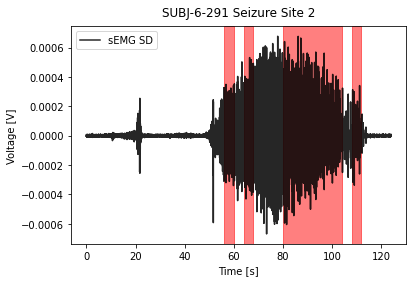

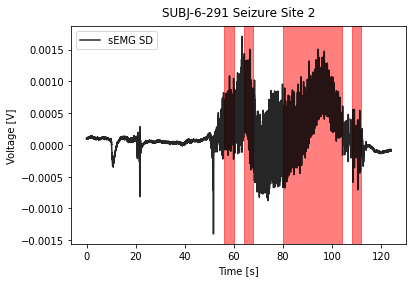

[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036, 0.04, 0.044, 0.048, 0.052, 0.056, 0.06, 0.064, 0.068, 0.072, 0.076, 0.08, 0.084, 0.088, 0.092, 0.096, 0.1, 0.104, 0.108, 0.112, 0.116, 0.12, 0.124, 0.128, 0.132, 0.136, 0.14, 0.144, 0.148, 0.152, 0.156, 0.16, 0.164, 0.168, 0.172, 0.176, 0.18, 0.184, 0.188, 0.192, 0.196, 0.2, 0.204, 0.208, 0.212, 0.216, 0.22, 0.224, 0.228, 0.232, 0.236, 0.24, 0.244, 0.248, 0.252, 0.256, 0.26, 0.264, 0.268, 0.272, 0.276, 0.28, 0.284, 0.288, 0.292, 0.296, 0.3, 0.304, 0.308, 0.312, 0.316, 0.32, 0.324, 0.328, 0.332, 0.336, 0.34, 0.344, 0.348, 0.352, 0.356, 0.36, 0.364, 0.368, 0.372, 0.376, 0.38, 0.384, 0.388, 0.392, 0.396, 0.4, 0.404, 0.408, 0.412, 0.416, 0.42, 0.424, 0.428, 0.432, 0.436, 0.44, 0.444, 0.448, 0.452, 0.456, 0.46, 0.464, 0.468, 0.472, 0.476, 0.48, 0.484, 0.488, 0.492, 0.496, 0.5, 0.504, 0.508, 0.512, 0.516, 0.52, 0.524, 0.528, 0.532, 0.536, 0.54, 0.544, 0.548, 0.552, 0.556, 0.56, 0.564, 0.568, 0.572, 0.576, 0.58, 0.584, 0.588,

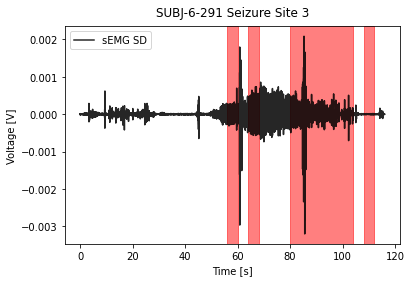

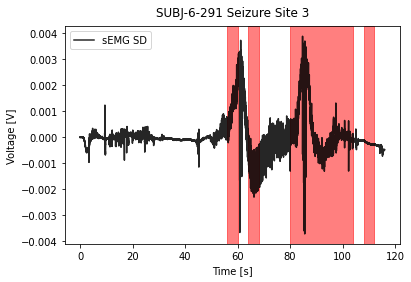

[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036, 0.04, 0.044, 0.048, 0.052, 0.056, 0.06, 0.064, 0.068, 0.072, 0.076, 0.08, 0.084, 0.088, 0.092, 0.096, 0.1, 0.104, 0.108, 0.112, 0.116, 0.12, 0.124, 0.128, 0.132, 0.136, 0.14, 0.144, 0.148, 0.152, 0.156, 0.16, 0.164, 0.168, 0.172, 0.176, 0.18, 0.184, 0.188, 0.192, 0.196, 0.2, 0.204, 0.208, 0.212, 0.216, 0.22, 0.224, 0.228, 0.232, 0.236, 0.24, 0.244, 0.248, 0.252, 0.256, 0.26, 0.264, 0.268, 0.272, 0.276, 0.28, 0.284, 0.288, 0.292, 0.296, 0.3, 0.304, 0.308, 0.312, 0.316, 0.32, 0.324, 0.328, 0.332, 0.336, 0.34, 0.344, 0.348, 0.352, 0.356, 0.36, 0.364, 0.368, 0.372, 0.376, 0.38, 0.384, 0.388, 0.392, 0.396, 0.4, 0.404, 0.408, 0.412, 0.416, 0.42, 0.424, 0.428, 0.432, 0.436, 0.44, 0.444, 0.448, 0.452, 0.456, 0.46, 0.464, 0.468, 0.472, 0.476, 0.48, 0.484, 0.488, 0.492, 0.496, 0.5, 0.504, 0.508, 0.512, 0.516, 0.52, 0.524, 0.528, 0.532, 0.536, 0.54, 0.544, 0.548, 0.552, 0.556, 0.56, 0.564, 0.568, 0.572, 0.576, 0.58, 0.584, 0.588,

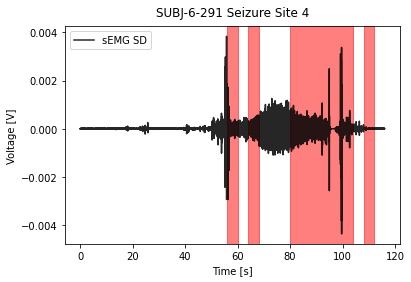

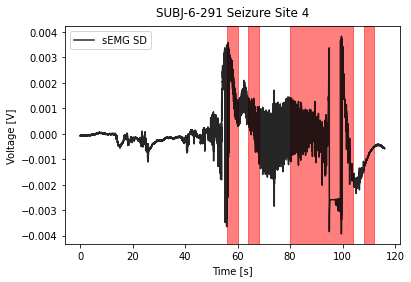

[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036, 0.04, 0.044, 0.048, 0.052, 0.056, 0.06, 0.064, 0.068, 0.072, 0.076, 0.08, 0.084, 0.088, 0.092, 0.096, 0.1, 0.104, 0.108, 0.112, 0.116, 0.12, 0.124, 0.128, 0.132, 0.136, 0.14, 0.144, 0.148, 0.152, 0.156, 0.16, 0.164, 0.168, 0.172, 0.176, 0.18, 0.184, 0.188, 0.192, 0.196, 0.2, 0.204, 0.208, 0.212, 0.216, 0.22, 0.224, 0.228, 0.232, 0.236, 0.24, 0.244, 0.248, 0.252, 0.256, 0.26, 0.264, 0.268, 0.272, 0.276, 0.28, 0.284, 0.288, 0.292, 0.296, 0.3, 0.304, 0.308, 0.312, 0.316, 0.32, 0.324, 0.328, 0.332, 0.336, 0.34, 0.344, 0.348, 0.352, 0.356, 0.36, 0.364, 0.368, 0.372, 0.376, 0.38, 0.384, 0.388, 0.392, 0.396, 0.4, 0.404, 0.408, 0.412, 0.416, 0.42, 0.424, 0.428, 0.432, 0.436, 0.44, 0.444, 0.448, 0.452, 0.456, 0.46, 0.464, 0.468, 0.472, 0.476, 0.48, 0.484, 0.488, 0.492, 0.496, 0.5, 0.504, 0.508, 0.512, 0.516, 0.52, 0.524, 0.528, 0.532, 0.536, 0.54, 0.544, 0.548, 0.552, 0.556, 0.56, 0.564, 0.568, 0.572, 0.576, 0.58, 0.584, 0.588,

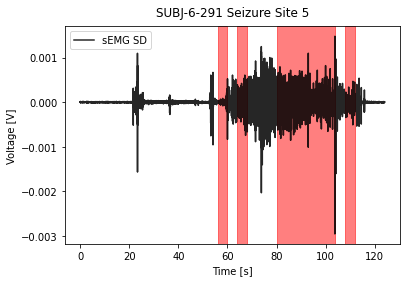

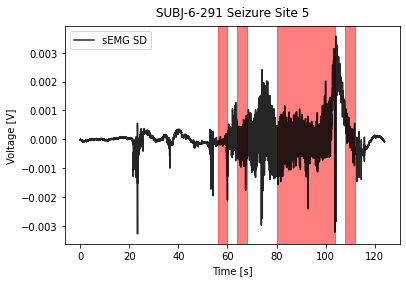

[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036, 0.04, 0.044, 0.048, 0.052, 0.056, 0.06, 0.064, 0.068, 0.072, 0.076, 0.08, 0.084, 0.088, 0.092, 0.096, 0.1, 0.104, 0.108, 0.112, 0.116, 0.12, 0.124, 0.128, 0.132, 0.136, 0.14, 0.144, 0.148, 0.152, 0.156, 0.16, 0.164, 0.168, 0.172, 0.176, 0.18, 0.184, 0.188, 0.192, 0.196, 0.2, 0.204, 0.208, 0.212, 0.216, 0.22, 0.224, 0.228, 0.232, 0.236, 0.24, 0.244, 0.248, 0.252, 0.256, 0.26, 0.264, 0.268, 0.272, 0.276, 0.28, 0.284, 0.288, 0.292, 0.296, 0.3, 0.304, 0.308, 0.312, 0.316, 0.32, 0.324, 0.328, 0.332, 0.336, 0.34, 0.344, 0.348, 0.352, 0.356, 0.36, 0.364, 0.368, 0.372, 0.376, 0.38, 0.384, 0.388, 0.392, 0.396, 0.4, 0.404, 0.408, 0.412, 0.416, 0.42, 0.424, 0.428, 0.432, 0.436, 0.44, 0.444, 0.448, 0.452, 0.456, 0.46, 0.464, 0.468, 0.472, 0.476, 0.48, 0.484, 0.488, 0.492, 0.496, 0.5, 0.504, 0.508, 0.512, 0.516, 0.52, 0.524, 0.528, 0.532, 0.536, 0.54, 0.544, 0.548, 0.552, 0.556, 0.56, 0.564, 0.568, 0.572, 0.576, 0.58, 0.584, 0.588,

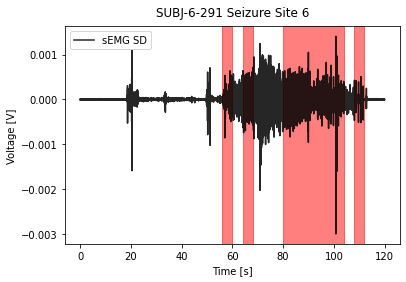

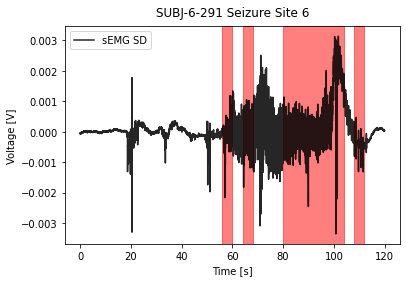

[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036, 0.04, 0.044, 0.048, 0.052, 0.056, 0.06, 0.064, 0.068, 0.072, 0.076, 0.08, 0.084, 0.088, 0.092, 0.096, 0.1, 0.104, 0.108, 0.112, 0.116, 0.12, 0.124, 0.128, 0.132, 0.136, 0.14, 0.144, 0.148, 0.152, 0.156, 0.16, 0.164, 0.168, 0.172, 0.176, 0.18, 0.184, 0.188, 0.192, 0.196, 0.2, 0.204, 0.208, 0.212, 0.216, 0.22, 0.224, 0.228, 0.232, 0.236, 0.24, 0.244, 0.248, 0.252, 0.256, 0.26, 0.264, 0.268, 0.272, 0.276, 0.28, 0.284, 0.288, 0.292, 0.296, 0.3, 0.304, 0.308, 0.312, 0.316, 0.32, 0.324, 0.328, 0.332, 0.336, 0.34, 0.344, 0.348, 0.352, 0.356, 0.36, 0.364, 0.368, 0.372, 0.376, 0.38, 0.384, 0.388, 0.392, 0.396, 0.4, 0.404, 0.408, 0.412, 0.416, 0.42, 0.424, 0.428, 0.432, 0.436, 0.44, 0.444, 0.448, 0.452, 0.456, 0.46, 0.464, 0.468, 0.472, 0.476, 0.48, 0.484, 0.488, 0.492, 0.496, 0.5, 0.504, 0.508, 0.512, 0.516, 0.52, 0.524, 0.528, 0.532, 0.536, 0.54, 0.544, 0.548, 0.552, 0.556, 0.56, 0.564, 0.568, 0.572, 0.576, 0.58, 0.584, 0.588,

True

In [ ]:
visualise_real_seizure_site(non_transformed, test_X_visualization, test_Y_visualization, visualize_predictions, test_mean, test_std, window_start, window_end)

In [ ]:
def get_fs(rec_name):
  truncated_name = rec_name
  lower_sampling = ['train025','train127', 'train163', 'train198', 'train203']

  lower_freq = 250
  higher_freq = 256
  higher_sampling = ['train177', 'train226', 'train178', 'train307', 'train256', 'train275',
                          'train291', 'train276', 'train353', 'train349', 'train357']

  if truncated_name in lower_sampling:
    return_sampling_rate = lower_freq
    
  
  elif truncated_name in higher_sampling:
    
    return_sampling_rate = higher_freq
    
  else: 
    print("NOT FOUND")
    pass
  
  return return_sampling_rate

In [ ]:
from scipy.fft import rfft, rfftfreq

In [ ]:
import math

def visualise_fourier_freq(site_ofI):
  patient_num = target[0][-3:]
  fs_string = 'train'+patient_num
  Fs = get_fs(fs_string)
  print('Sampling Frequency: ', Fs)

  signal_len_x = len(site_ofI)
  yf = rfft(site_ofI)
  print('YF Sum', sum(abs(yf)))
  xf = rfftfreq(signal_len_x, 1 / Fs)
  print('Site shape: ', np.shape(site_ofI))
  print('yf shape: ', np.shape(yf))
  print('xf shape: ', np.shape(xf))

  plt.plot(xf, abs(yf), color = 'k',alpha = 0.85)
  plt.title("{} Frequency Power Spectrum".format(patient_ID), pad = 10)
  plt.xlabel('Freq [Hz]')
  plt.ylabel('Power Spectral Density '+r'$[μV^2]$')
  plt.show()
    

  return True

In [ ]:
def visualize_false_detections(non_transformed, sequence_data, pred_count, pred_start, pred_end, mean_test, stdev_test):

  for i in range(0, len(pred_count)):
    print("Number: ", i)
    if pred_count[i] == 1:

      print("Start Location of the SITE: ", pred_start[i])
      print("End Location of the SITE", pred_end[i])
      
      false_seizure_site = sequence_data[pred_start[i]]
      false_org = non_transformed[pred_start[i]]
      whole_seizure_site = false_seizure_site
      whole_org = false_org

      print(np.shape(whole_seizure_site))

      visualise_fourier_freq(np.ndarray.flatten(whole_seizure_site*stdev_test + mean_test))
    
    elif pred_count[i] > 1:
      print("Longer Detection - Could be a seizure")
      # Get seizure site data

      print("Start Location of the SITE: ", pred_start[i])
      print("End Location of the SITE", pred_end[i])



      false_seizure_site = sequence_data[pred_start[i]:pred_end[i]+1]
      false_org = non_transformed[pred_start[i]:pred_end[i]+1]
      # Get shape of the seizure site array
      rows, columns,_ = np.shape(false_seizure_site)

      # reshape to 2D format:
      false_seizure_site = false_seizure_site.reshape(rows, columns)
      false_org = false_org.reshape(rows, columns)


      whole_seizure_site = np.ndarray.flatten(false_seizure_site)
      whole_org = np.ndarray.flatten(false_org)


      visualise_fourier_freq(whole_seizure_site*stdev_test + mean_test)


    time_on_site = list(range(0, len(whole_seizure_site)))
    time_on_site_seconds= [x*4/1000 for x in time_on_site]


    # ________________PLOT FREQUENCY POWER SPECTRUM_______________
    #visualise_fourier_freq(whole_seizure_site)

    #________________________PLOT descaled________________________
    print("DESCALED")
    whole_seizure_site_destandardized = whole_seizure_site *stdev_test + mean_test

    plt.plot(time_on_site_seconds, whole_seizure_site_destandardized, color = 'k', alpha = 0.85)
    #plt.title('True positive Prediction {}'.format(patient_ID), pad = 10)
    plt.title('False positive Prediction {}'.format(patient_ID), pad = 10)
    plt.ylabel('Voltage [V]')
    plt.xlabel('Seizure Site Time [s]')
    plt.legend(['sEMG SD'], loc='upper left')
    plt.show()

    print("ORIGINAL")
    #________________________PLOT org_______________________
    plt.plot(time_on_site_seconds, whole_org, color = 'k', alpha = 0.85)
    #plt.title('True positive Prediction {}'.format(patient_ID), pad = 10)
    plt.title('False positive Prediction {}'.format(patient_ID), pad = 10)
    plt.ylabel('Voltage [V]')
    plt.xlabel('Time [s]')
    plt.legend(['sEMG SD'], loc='upper left')
    plt.show()

    #____________________ RMS CALCULATION___________________________________
    print("FALSE POSITIVE RMS CALCULATION")

    if pred_count[i] == 1:
      print("4 second False Positive")
      x_RS_total = np.sum(np.square(whole_seizure_site_destandardized))
      #4 seconds
      x_RMS_per_second = sqrt((np.sum(np.square(whole_seizure_site_destandardized)))/4)
      # 1000 datapoints
      x_RMS_proper = sqrt((np.sum(np.square(whole_seizure_site_destandardized)))/1000)
      print("RS per SECOND OF RECORDING: ", x_RMS_per_second)
      print("RMS proper formula: ", x_RMS_proper )
      print("RMS cumulative", x_RS_total)
    elif pred_count[i] > 1:
      print("Consequite False Positives")
      x_RS_total = np.sum(np.square(whole_seizure_site_destandardized))
      #4 seconds
      x_RMS_per_second = sqrt((np.sum(np.square(whole_seizure_site_destandardized)))/int(time_on_site_seconds[-1]))
      # 1000 datapoints
      x_RMS_proper = sqrt((np.sum(np.square(whole_seizure_site_destandardized)))/len(whole_seizure_site_destandardized))
      print("WHOLEEEEEEEEE LENNNNNNNNNNNNN: ", len(whole_seizure_site_destandardized))
      print("RS per SECOND OF RECORDING: ", x_RMS_per_second)
      print("RMS proper formula: ", x_RMS_proper )
      print("RMS cumulative", x_RS_total)


  return True

In [ ]:
# CORRESPONDING TO THE LAYERS
def visualize_false_detections(non_transformed, sequence_data, pred_count, pred_start, pred_end, mean_test, stdev_test):

  for i in range(0, len(pred_count)):
    print("Number: ", i)
    if pred_count[i] == 1:

      print("Start Location of the SITE: ", pred_start[i])
      print("End Location of the SITE", pred_end[i])
      
      false_seizure_site = sequence_data[pred_start[i]]
      false_org = non_transformed[pred_start[i]]
      whole_seizure_site = false_seizure_site
      whole_org = false_org

      print(np.shape(whole_seizure_site))

      visualise_fourier_freq(np.ndarray.flatten(whole_seizure_site*stdev_test + mean_test), i)
    
    elif pred_count[i] > 1:
      print("Longer Detection - Could be a seizure")
      # Get seizure site data

      print("Start Location of the SITE: ", pred_start[i])
      print("End Location of the SITE", pred_end[i])



      false_seizure_site = sequence_data[pred_start[i]:pred_end[i]+1]
      false_org = non_transformed[pred_start[i]:pred_end[i]+1]
      # Get shape of the seizure site array
      rows, columns,_ = np.shape(false_seizure_site)

      # reshape to 2D format:
      false_seizure_site = false_seizure_site.reshape(rows, columns)
      false_org = false_org.reshape(rows, columns)


      whole_seizure_site = np.ndarray.flatten(false_seizure_site)
      whole_org = np.ndarray.flatten(false_org)


      visualise_fourier_freq((np.ndarray.flatten(whole_seizure_site*stdev_test + mean_test)), i)


    time_on_site = list(range(0, len(whole_seizure_site)))
    time_on_site_seconds= [x*4/1000 for x in time_on_site]


    # ________________PLOT FREQUENCY POWER SPECTRUM_______________
    #visualise_fourier_freq(whole_seizure_site)

    #________________________PLOT descaled________________________
    print("DESCALED")
    whole_seizure_site_destandardized = whole_seizure_site *stdev_test + mean_test

    plt.plot(time_on_site_seconds, whole_seizure_site_destandardized, color = 'k', alpha = 0.85)
    #plt.title('True positive Prediction {}'.format(patient_ID), pad = 10)
    plt.title('False positive Prediction {}'.format(patient_ID), pad = 10)
    plt.ylabel('Voltage [V]')
    plt.xlabel('Seizure Site Time [s]')
    plt.legend(['sEMG SD'], loc='upper left')
    plt.show()

    print("ORIGINAL")
    #________________________PLOT org_______________________
    plt.plot(time_on_site_seconds, whole_org, color = 'k', alpha = 0.85)
    #plt.title('True positive Prediction {}'.format(patient_ID), pad = 10)
    plt.title('False positive Prediction {}'.format(patient_ID), pad = 10)
    plt.ylabel('Voltage [V]')
    plt.xlabel('Time [s]')
    plt.legend(['sEMG SD'], loc='upper left')
    plt.show()

    #____________________ RMS CALCULATION___________________________________
    print("FALSE POSITIVE RMS CALCULATION")

    if pred_count[i] == 1:
      print("4 second False Positive")
      x_RS_total = np.sum(np.square(whole_seizure_site_destandardized))
      #4 seconds
      x_RMS_per_second = sqrt((np.sum(np.square(whole_seizure_site_destandardized)))/4)
      # 1000 datapoints
      x_RMS_proper = sqrt((np.sum(np.square(whole_seizure_site_destandardized)))/1000)
      print("RS per SECOND OF RECORDING: ", x_RMS_per_second)
      print("RMS proper formula: ", x_RMS_proper )
      print("RMS cumulative", x_RS_total)
    elif pred_count[i] > 1:
      print("Consequite False Positives")
      x_RS_total = np.sum(np.square(whole_seizure_site_destandardized))
      #4 seconds
      x_RMS_per_second = sqrt((np.sum(np.square(whole_seizure_site_destandardized)))/int(time_on_site_seconds[-1]))
      # 1000 datapoints
      x_RMS_proper = sqrt((np.sum(np.square(whole_seizure_site_destandardized)))/len(whole_seizure_site_destandardized))
      print("WHOLEEEEEEEEE LENNNNNNNNNNNNN: ", len(whole_seizure_site_destandardized))
      print("RS per SECOND OF RECORDING: ", x_RMS_per_second)
      print("RMS proper formula: ", x_RMS_proper )
      print("RMS cumulative", x_RS_total)


  return True

In [ ]:
# TRUE POSTIIVE = 1430
# FALSE POSITIVE = 69891
# TRUE NEGATIVE = 21000
# FALSE NEGATIVE 1415

counts = [1, 1, 1, 1]
start =  [1415, 1430,21000, 69891]
end = [1415, 1430, 21000, 69891]

Number:  0
Start Location of the SITE:  1415
End Location of the SITE 1415
(1000, 1)
Sampling Frequency:  256
YF Sum 0.03147758454247657
Site shape:  (1000,)
yf shape:  (501,)
xf shape:  (501,)


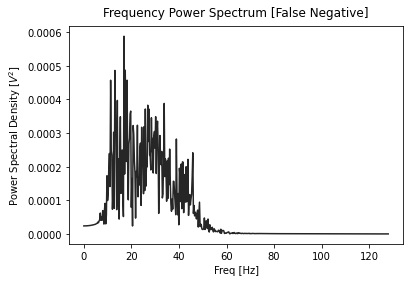

DESCALED


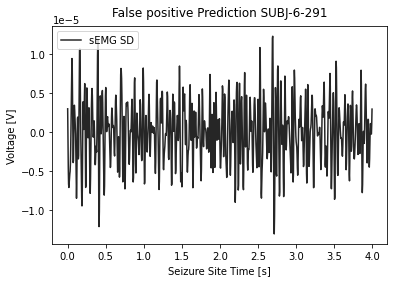

ORIGINAL


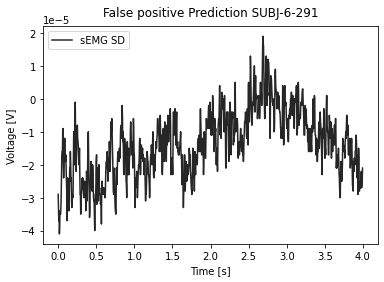

FALSE POSITIVE RMS CALCULATION
4 second False Positive
RS per SECOND OF RECORDING:  6.10847553489127e-05
RMS proper formula:  3.8633391443343515e-06
RMS cumulative 1.492538934414608e-08
Number:  1
Start Location of the SITE:  1430
End Location of the SITE 1430
(1000, 1)
Sampling Frequency:  256
YF Sum 1.2405089733965622
Site shape:  (1000,)
yf shape:  (501,)
xf shape:  (501,)


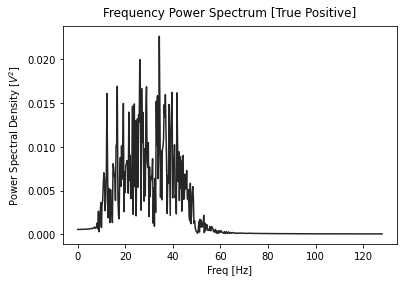

DESCALED


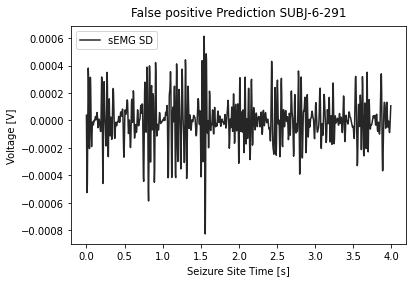

ORIGINAL


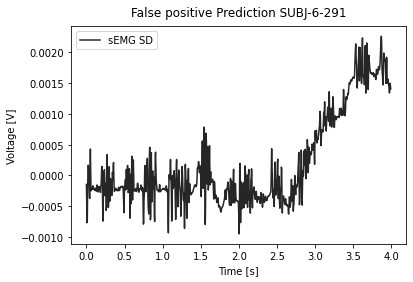

FALSE POSITIVE RMS CALCULATION
4 second False Positive
RS per SECOND OF RECORDING:  0.002446566133482809
RMS proper formula:  0.0001547344285607443
RMS cumulative 2.3942743382020084e-05
Number:  2
Start Location of the SITE:  21000
End Location of the SITE 21000
(1000, 1)
Sampling Frequency:  256
YF Sum 0.029220149867648117
Site shape:  (1000,)
yf shape:  (501,)
xf shape:  (501,)


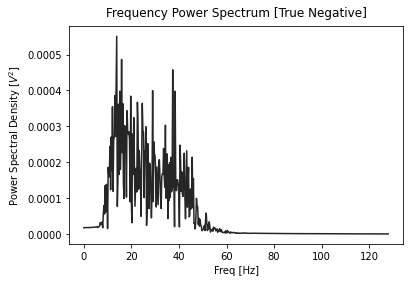

DESCALED


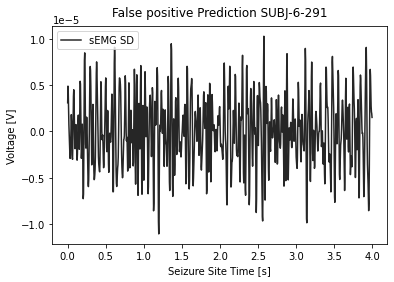

ORIGINAL


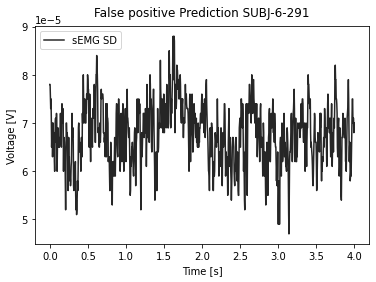

FALSE POSITIVE RMS CALCULATION
4 second False Positive
RS per SECOND OF RECORDING:  5.758391910234718e-05
RMS proper formula:  3.6419268192459138e-06
RMS cumulative 1.326363095674266e-08
Number:  3
Start Location of the SITE:  69891
End Location of the SITE 69891
(1000, 1)
Sampling Frequency:  256
YF Sum 7.480081812596813
Site shape:  (1000,)
yf shape:  (501,)
xf shape:  (501,)


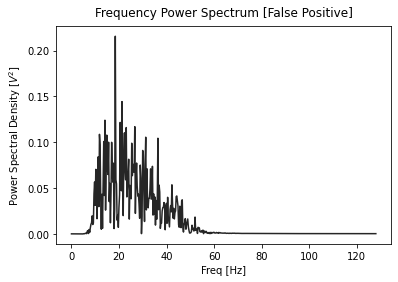

DESCALED


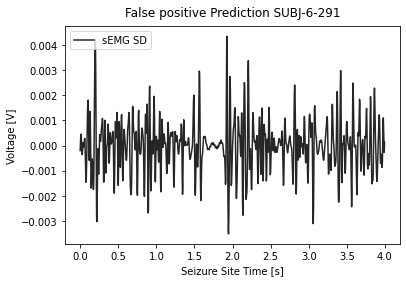

ORIGINAL


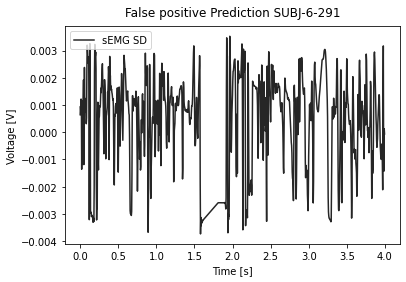

FALSE POSITIVE RMS CALCULATION
4 second False Positive
RS per SECOND OF RECORDING:  0.015827547015535424
RMS proper formula:  0.0010010219668498473
RMS cumulative 0.001002044978115937


True

In [ ]:
visualize_false_detections(non_transformed, test_X, counts, start, end, test_mean, test_std)

Layer Visualization

In [ ]:
from tensorflow.keras.models import Model

# Choose of input!:
input_index = 1430
x_to_predict = np.matrix(test_X[input_index,:,:])
x_predict = np.expand_dims(x_to_predict,0)
time_on_site = list(range(0, len(x_predict[0,:,:])))
time_on_site_seconds= [x*4/1000 for x in time_on_site]

for i in range(1,16):
  intermediate_layer_index = i
  intermediate_layer_model = Model(inputs=model.input,
                                  outputs=model.get_layer(index=intermediate_layer_index).output)
    # Choose of input!:

  x_predict = np.matrix(test_X[input_index,:,:])
  x_predict = np.expand_dims(x_predict,0)
  intermediate_output = intermediate_layer_model.predict(x_predict)
  print("Layer_i:{}, outputshape: {} ".format(i, np.shape(intermediate_output)))

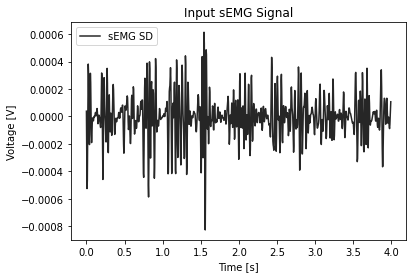

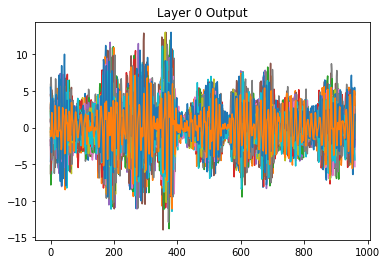

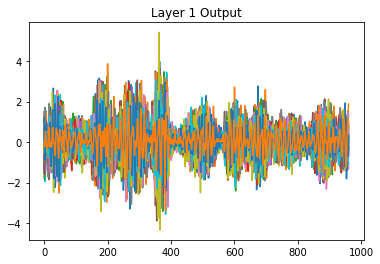

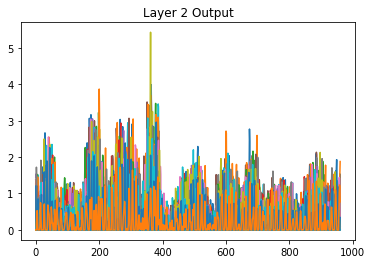

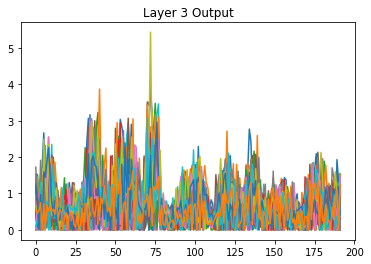

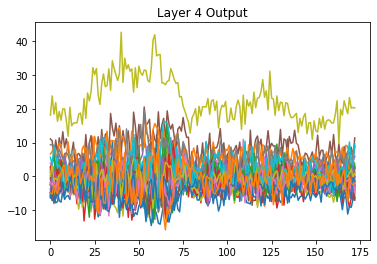

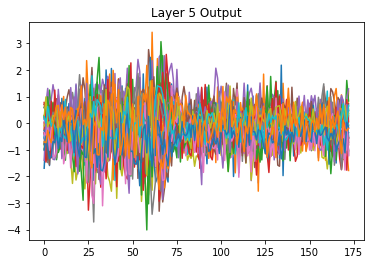

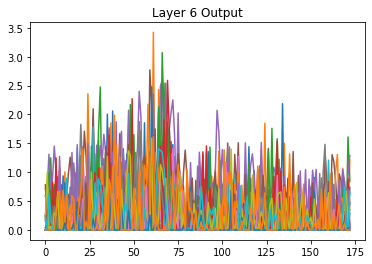

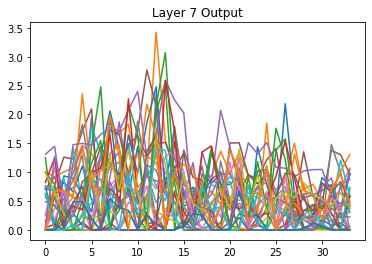

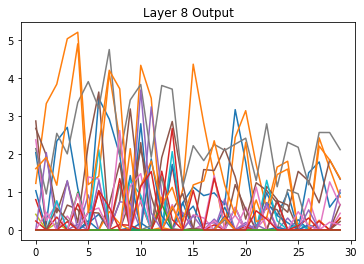

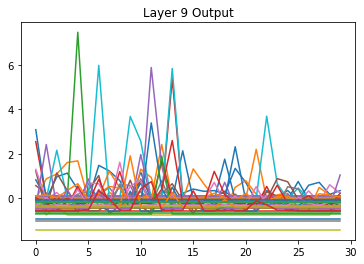

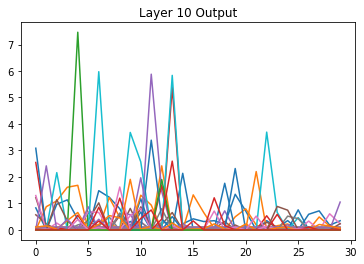

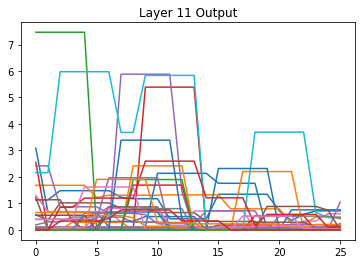

i:12, outputshape: (1, 26, 64) 


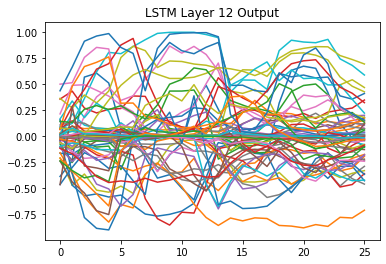

i:13, outputshape: (1, 64) 


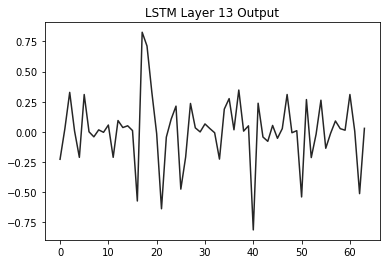

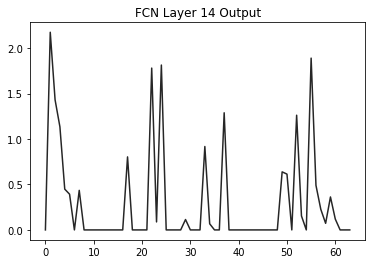

i:15, outputshape: (1, 1) 


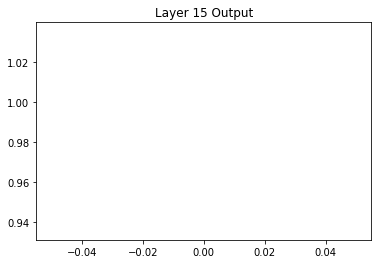

SIGMOID OUTPUT:  [[0.98542297]]


In [ ]:
from tensorflow.keras.models import Model

# Choice of input time-window index:
input_index = 0
x_to_predict = np.matrix(test_X[input_index,:,:])
x_predict = np.expand_dims(x_to_predict,0)
time_on_site = list(range(0, len(x_predict[0,:,:])))
time_on_site_seconds= [x*4/1000 for x in time_on_site]



plt.plot(time_on_site_seconds, x_predict[0,:,:]*test_std + test_mean, color = 'k',alpha = 0.85)
plt.title('Input sEMG Signal')
plt.ylabel('Voltage [V]')
plt.xlabel('Time [s]')
plt.legend(['sEMG SD'], loc='upper left')
plt.show()


for i in range(0,16):


  if i == 15:
    intermediate_layer_index = i
    intermediate_layer_model = Model(inputs=model.input,
                                  outputs=model.get_layer(index=intermediate_layer_index).output)
    # Choose of input!:

    x_predict = np.matrix(test_X[input_index,:,:])
    x_predict = np.expand_dims(x_predict,0)
    intermediate_output = intermediate_layer_model.predict(x_predict)
    print("i:{}, outputshape: {} ".format(i, np.shape(intermediate_output)))
    plt.plot(intermediate_output[0,:],color = 'k',alpha = 0.85 )
    plt.title('Layer {} Output'.format(intermediate_layer_index))
    plt.show()

    print("SIGMOID OUTPUT: ", intermediate_output)

  elif i == 12:
    intermediate_layer_index = i
    intermediate_layer_model = Model(inputs=model.input,
                                  outputs=model.get_layer(index=intermediate_layer_index).output)
    # Choose of input!:

    x_predict = np.matrix(test_X[input_index,:,:])
    x_predict = np.expand_dims(x_predict,0)
    intermediate_output = intermediate_layer_model.predict(x_predict)
    print("i:{}, outputshape: {} ".format(i, np.shape(intermediate_output)))
    plt.plot(intermediate_output[0,:])
    plt.title('LSTM Layer {} Output'.format(intermediate_layer_index))
    plt.show()
    

  elif i == 13:
    intermediate_layer_index = i
    intermediate_layer_model = Model(inputs=model.input,
                                  outputs=model.get_layer(index=intermediate_layer_index).output)
    # Choose of input!:

    x_predict = np.matrix(test_X[input_index,:,:])
    x_predict = np.expand_dims(x_predict,0)
    intermediate_output = intermediate_layer_model.predict(x_predict)
    print("i:{}, outputshape: {} ".format(i, np.shape(intermediate_output)))
    plt.plot(intermediate_output[0,:],color = 'k',alpha = 0.85 )
    plt.title('LSTM Layer {} Output'.format(intermediate_layer_index))
    plt.show()


  elif i == 14:
    intermediate_layer_index = i
    intermediate_layer_model = Model(inputs=model.input,
                                  outputs=model.get_layer(index=intermediate_layer_index).output)
    # Choose of input!:

    x_predict = np.matrix(test_X[input_index,:,:])
    x_predict = np.expand_dims(x_predict,0)
    intermediate_output = intermediate_layer_model.predict(x_predict)
    plt.plot(intermediate_output[0,:],color = 'k',alpha = 0.85)
    plt.title('FCN Layer {} Output'.format(intermediate_layer_index))
    plt.show()

 
  else: 


    intermediate_layer_index = i
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=intermediate_layer_index).output)
    # Choose of input!:

    x_predict = np.matrix(test_X[input_index,:,:])
    x_predict = np.expand_dims(x_predict,0)
    intermediate_output = intermediate_layer_model.predict(x_predict)
    plt.plot(intermediate_output[0,:,:])
    plt.title('Layer {} Output'.format(intermediate_layer_index))
    plt.show()
    if i==12:
      print("i:{}, outputshape: {} ".format(i, np.shape(intermediate_output)))